# Autoregressive Integrated Moving Average (ARIMA) 
- The $ARIMA(p,d,q)$ model can be applied on non-stationary time series and has the added advantage of returning forecasts in the same scale as the original series.
- The order of integration $d$ defines how many times a series must be differenced to become stationary. 
    - This parameter then allows us to fit the model on the original series and get a forecast in the same scale, unlike the ARMA(p,q) model, which required the series to be stationary using transformations (differencing) for the model to be applied and required to reverse the transformations on the forecasts.
- To apply the ARIMA(p,d,q) model, we added an extra step to our **general modeling procedure**, which simply involves finding the value for the order of integration $d$. 

## Introduction
- An autoregressive integrated moving average  $ARIMA(p,d,q)$  process is the combination of 
    - Autoregressive process $AR(p)$
    - Integration $I(d)$
    - Moving average process $MA(q)$.
- ARIMA model is simply an ARMA model that can be applied on **non-stationary** time series. 
    - The ARMA(p,q) model requires the series to be stationary **before** fitting an ARMA(p,q) model
    - The ARIMA(p,d,q) model can be used on **non-stationary** series.
- ARIMA process uses the differenced series ($y_t'$) instead of using the original series ($y_t$)
    - **Note**: that $y_t'$ can represent a series that has been differenced more than once.
- The general equation of the ARIMA process:

$$y_t' = C + \varphi_1y_{t–1}' + \varphi_2y_{t–2}' +⋅⋅⋅+ \varphi_p y_{t–p}' + \epsilon_t + \theta_1\epsilon_{t-1}' + ... + \theta_q\epsilon_{t-q}'$$

In [1]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import pandas as pd
import numpy as np
import plotly.express as px

from itertools import product
from tqdm import tqdm
from typing import Union, Tuple
import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

## General Modeling Procedure for non-stationary series

In [6]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/jj.csv",
                 parse_dates=[0]
)

fig = px.line(df, x='date', y='data')
fig.update_layout(
    yaxis_title='Earnings per share (USD)',
    xaxis_title='Month',
    title='Quarterly earnings per share (EPS) of Johnson & Johnson between 1960 and 1980'
)  

- Step 1: to determine how many times $d$ the series must be differenced to become stationary. 

In [44]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [45]:
check_stationarity(df['data'])

ADF Statistic : 2.74202, p-value: 1.00000
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
KPSS Statistic: 1.36349, p-value: 0.01000
Non-stationary


In [46]:
eps_diff = np.diff(df['data'], n=1) 
check_stationarity(eps_diff)

ADF Statistic : -0.40741, p-value: 0.90885
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
KPSS Statistic: 0.22140, p-value: 0.10000
Non-stationary


In [47]:
eps_diff2 = np.diff(eps_diff, n=1)  
check_stationarity(eps_diff2)

ADF Statistic : -3.58516, p-value: 0.00605
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589
KPSS Statistic: 0.09272, p-value: 0.10000
Stationary


- It took two rounds of differencing to make our data stationary, which means that our order of integration is 2, so $d = 2$.

- Step 2: use **general modeling procedure** to determine $p$ and $q$
- Step 2.1 - model selection with AIC:

In [48]:
# train-test split
# train: from 1960 to 1979
# test: predict the quarterly EPS in 1980 to evaluate the quality of our model against the observed values in 1980.
train = df['data'][:-4]

In [49]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try:
            # furthermore, d=2 must be constant in order to compare models using the AIC. 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [50]:
ps = range(0, 4, 1) # p from 0 inclusively to 4 exclusively, with steps of 1.
qs = range(0, 4, 1) # q from 0 inclusively to 4 exclusively, with steps of 1.
d = 2

order_list = list(product(ps, qs))

In [51]:
result_df = optimize_ARIMA(train, order_list, d) # fixing d=2
result_df.head()

100%|██████████| 16/16 [00:00<00:00, 28.32it/s]


,"(p,q)",AIC
0,"(3, 3)",115.269235
1,"(3, 1)",115.624981
2,"(3, 2)",115.672007
3,"(3, 0)",154.430633
4,"(0, 3)",194.654716


- The result shows that (p=3, q=3) results in the lowest AIC. 
- Therefore, an ARIMA(3,2,3) model seems to be the most suitable for this situation.

- Step 2.2 - Qualitative analysis with Q-Q plot: fit an ARIMA(3,2,3) model on the training set and display the **residuals’ diagnostics** using the `plot_diagnostics` method.

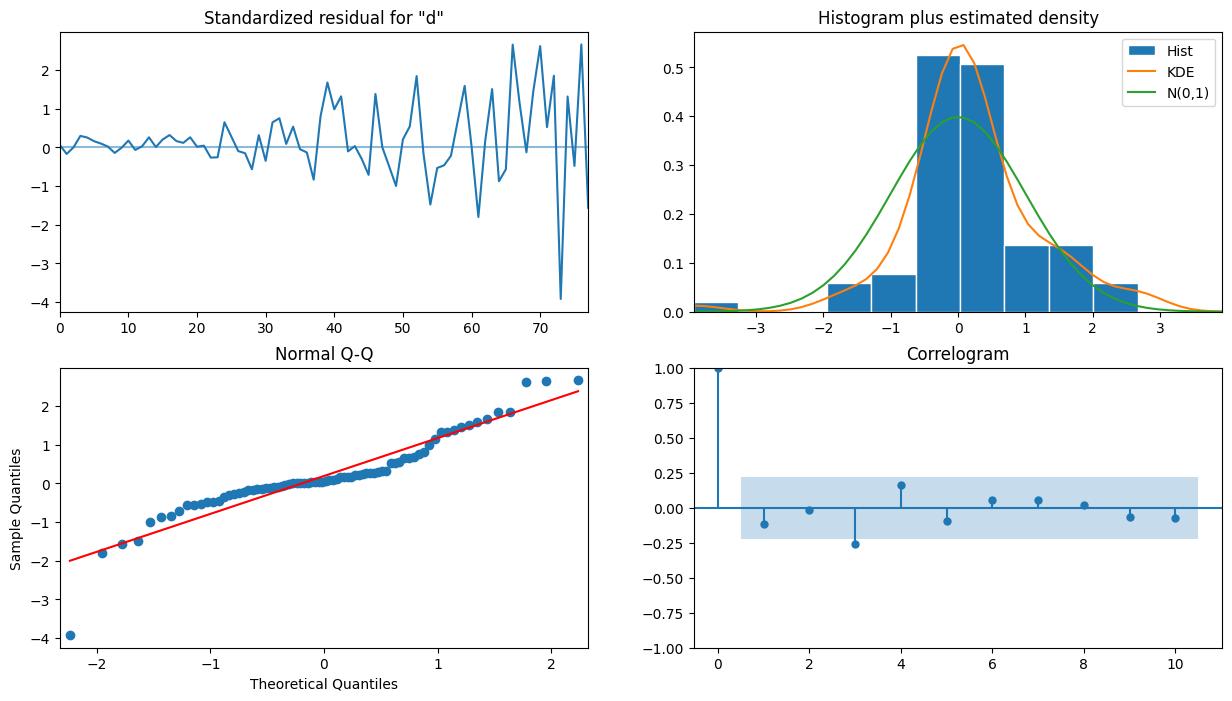

In [52]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)  
model_fit = model.fit(disp=False)
 
model_fit.plot_diagnostics(figsize=(15,8));

- The top-left plot shows the residuals over time. 
    - While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. 
- The top right is the distribution of the residuals. We can see it is fairly close to a normal distribution. 
- The bottom left is the Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
- The bottom right is the correlogramthat a coefficient seems to be significant at lag 3. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. 
    - Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.

- Step 2.3 - Quantitative analysis on the residuals with Ljung-Box test: apply the Ljung-Box test to determine whether the residuals are correlated.
    - Running the Ljung-Box test on the first 10 lags of the model’s residuals returns a list of p-values that are all larger than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are not correlated, just like white noise.
    - ARIMA(3,2,3) model has passed all the checks, and it can now be used for forecasting.

In [53]:
residuals = model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

True

- Step 3 - forecasting with ARIMA(3,2,3)
    - Baseline model: naive seasonal method. This means that we’ll take the EPS of the first quarter of 1979 and use it as a forecast for the EPS of the first quarter of 1980. Then the EPS of the second quarter of 1979 will be used as a forecast for the EPS of the second quarter of 1980, and so on. 

In [54]:
test = df.iloc[-4:] 
test['naive_seasonal'] = df['data'].iloc[76:80].values # baseline prediction

In [55]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean  # this is to get the prediction for timestep 80 to timestep 83 
test['ARIMA_pred'] = ARIMA_pred                                 

In [56]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, order: Tuple[int, int, int]) -> list:
    total_len = train_len + horizon
    pred = []
        
    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=order)
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)  # get prediction from timestep 0 to 80+2-1 (if window=2)
        oos_pred = predictions.predicted_mean.iloc[-window:] # get only the prediction  [-2:]
        pred.extend(oos_pred)
        
    return pred

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 # 1 steps at the time for the prediction
ARIMA_pred_rolling = rolling_forecast(df['data'], TRAIN_LEN, HORIZON, WINDOW, (3,2,3))
test['ARIMA_pred_rolling'] = ARIMA_pred_rolling

In [58]:
def mape(y_true, y_pred):                                          
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for pred_type in ['naive_seasonal', 'ARIMA_pred', 'ARIMA_pred_rolling']:
    mape_result = mape(test['data'], test[pred_type])  
    print(f"{pred_type:20}: MAPE={mape_result:.2f}%")


naive_seasonal      : MAPE=11.56
ARIMA_pred          : MAPE=1.72
ARIMA_pred_rolling  : MAPE=2.21


- MAPE for the naive seasonal forecast is 11.56%
- MAPE for the ARIMA(3,2,3) model is 1.72%, which roughly one fifth of the benchmark value. 
    - This means that our predictions are on average 1.72% off from the actual values. 
- MAPE for the ARIMA(3,2,3) model if using the rolling forecast is 2.21%, which is a little bit higher than without using rolling forecast (1.72%), which is understanable as we only have 4 data points in the test set.
- The ARIMA(3,2,3) model is clearly a better model than the naive seasonal method.